In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data preprocessing and transformation
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder

# Clustering
from sklearn.cluster import KMeans

# Dimensionality reduction
from sklearn.manifold import TSNE
# Regression models
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Model evaluation and selection
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

In [3]:
# Load the dataset
data = pd.read_csv("C:\\Users\\pooja\\zomato analysing\\zomato.csv")

# Display the first few rows of the dataset
data.head()

,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),listed_in(type)
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,Buffet
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,Buffet
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,Buffet
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,Buffet
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,Buffet


In [4]:
# Define a function to clean 'online_order' and 'book_table' columns
def clean_binary_columns(value):
    if value == 'Yes':
        return 1
    elif value == 'No':
        return 0
    else:
        return pd.NaT

# Clean 'online_order' and 'book_table' columns
data['online_order'] = data['online_order'].apply(clean_binary_columns)
data['book_table'] = data['book_table'].apply(clean_binary_columns)
# Remove '/5' from 'rate' and convert to numeric
data['rate'] = data['rate'].str.replace('/5', '')
data['rate'] = pd.to_numeric(data['rate'], errors='coerce')

# Convert 'votes' to numeric
data['votes'] = pd.to_numeric(data['votes'], errors='coerce')

# Remove commas from 'approx_cost(for two people)' and convert to numeric
data['approx_cost(for two people)'] = data['approx_cost(for two people)'].str.replace(',', '')
data['approx_cost(for two people)'] = pd.to_numeric(data['approx_cost(for two people)'], errors='coerce')

# Define a function to clean 'location', 'rest_type', 'cuisines', and 'listed_in(type)' columns
def clean_categorical_columns(value, common_values):
    if pd.isnull(value):
        return pd.NaT
    elif value in common_values:
        return value
    else:
        return 'Other'

# Keep top 10 most common locations, restaurant types, cuisines, and types
top_locations = data['location'].value_counts()[:10].index.tolist()
top_rest_types = data['rest_type'].value_counts()[:10].index.tolist()
top_cuisines = data['cuisines'].value_counts()[:10].index.tolist()
top_types = data['listed_in(type)'].value_counts()[:10].index.tolist()

# Clean 'location', 'rest_type', 'cuisines', and 'listed_in(type)' columns
data['location'] = data['location'].apply(clean_categorical_columns, common_values=top_locations)
data['rest_type'] = data['rest_type'].apply(clean_categorical_columns, common_values=top_rest_types)
data['cuisines'] = data['cuisines'].apply(clean_categorical_columns, common_values=top_cuisines)
data['listed_in(type)'] = data['listed_in(type)'].apply(clean_categorical_columns, common_values=top_types)

# Check for missing values in the data
data.isna().sum()


address                           17
name                              16
online_order                    4535
book_table                      4535
rate                           14587
votes                           4535
phone                           1296
location                         126
rest_type                        338
dish_liked                     28225
cuisines                         203
approx_cost(for two people)     4881
listed_in(type)                 4610
dtype: int64

In [5]:
# Impute missing values in 'online_order' and 'book_table' with the mode
for col in ['online_order', 'book_table']:
    data[col] = data[col].fillna(data[col].mode().iloc[0])

# Impute missing values in 'rate' and 'votes' with the median
for col in ['rate', 'votes']:
    data[col] = data[col].fillna(data[col].median())

# Impute missing values in 'location', 'rest_type', 'cuisines', and 'listed_in(type)' with 'Unknown'
for col in ['location', 'rest_type', 'cuisines', 'listed_in(type)']:
    data[col] = data[col].fillna('Unknown')
# Check for missing values in the data again
data.isna().sum()

address                           17
name                              16
online_order                       0
book_table                         0
rate                               0
votes                              0
phone                           1296
location                           0
rest_type                          0
dish_liked                     28225
cuisines                           0
approx_cost(for two people)     4881
listed_in(type)                    0
dtype: int64

In [6]:
# Drop the 'phone' and 'dish_liked' columns
data = data.drop(columns=['phone', 'dish_liked'])

# Impute missing values in 'approx_cost(for two people)' with the median
data['approx_cost(for two people)'] = data['approx_cost(for two people)'].fillna(data['approx_cost(for two people)'].median())

# Check for missing values in the data again
data.isna().sum()

address                        17
name                           16
online_order                    0
book_table                      0
rate                            0
votes                           0
location                        0
rest_type                       0
cuisines                        0
approx_cost(for two people)     0
listed_in(type)                 0
dtype: int64

In [7]:
# Drop the 'address' and 'name' columns
data = data.drop(columns=['address', 'name'])

# Check for missing values in the data again
data.isna().sum()

online_order                   0
book_table                     0
rate                           0
votes                          0
location                       0
rest_type                      0
cuisines                       0
approx_cost(for two people)    0
listed_in(type)                0
dtype: int64

EDA visulization

In [8]:
# Display a summary of the dataset
display(data.describe(include='all'))

# Display unique values in the categorical columns
for col in ['location', 'rest_type', 'cuisines', 'listed_in(type)']:
    print(f'{col}:\n{data[col].unique()}\n')

,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type)
count,56252.000000,56252.000000,56252.000000,56252.000000,56252,56252,56252,56252.000000,56252
unique,NaN,NaN,NaN,NaN,12,12,12,NaN,12
top,NaN,NaN,NaN,NaN,Other,Quick Bites,Other,NaN,Delivery
freq,NaN,NaN,NaN,NaN,32824,19132,43392,NaN,24317
mean,0.621827,0.114645,3.700332,264.131409,NaN,NaN,NaN,541.944731,NaN
std,0.484935,0.318596,0.379118,773.582003,NaN,NaN,NaN,421.655078,NaN
min,0.000000,0.000000,1.800000,0.000000,NaN,NaN,NaN,40.000000,NaN
25%,0.000000,0.000000,3.500000,8.000000,NaN,NaN,NaN,300.000000,NaN
50%,1.000000,0.000000,3.700000,41.000000,NaN,NaN,NaN,400.000000,NaN
75%,1.000000,0.000000,3.900000,171.000000,NaN,NaN,NaN,600.000000,NaN


location:
['Other' 'Jayanagar' 'JP Nagar' 'Bannerghatta Road' 'BTM' 'Unknown' 'HSR'
 'Marathahalli' 'Koramangala 5th Block' 'Bellandur' 'Whitefield'
 'Indiranagar']

rest_type:
['Casual Dining' 'Other' 'Quick Bites' 'Cafe' 'Delivery' 'Dessert Parlor'
 'Bakery' 'Takeaway, Delivery' 'Beverage Shop' 'Bar' 'Casual Dining, Bar'
 'Unknown']

cuisines:
['Other' 'North Indian' 'Cafe' 'Bakery, Desserts' 'Biryani' 'South Indian'
 'North Indian, Chinese' 'Bakery' 'Fast Food' 'Desserts'
 'South Indian, North Indian, Chinese' 'Unknown']

listed_in(type):
['Buffet' 'Cafes' 'Unknown' 'Other' 'Delivery' " ('Rated 4.0'" 'Desserts'
 'Dine-out' 'Drinks & nightlife' " ('Rated 3.0'" " ('Rated 5.0'"
 'Pubs and bars']



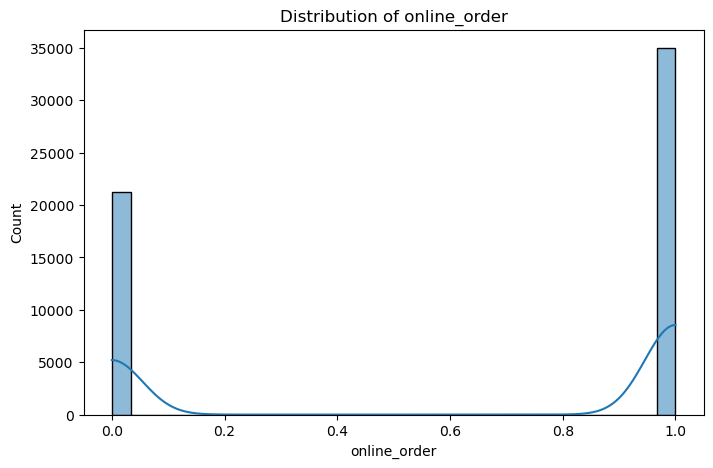

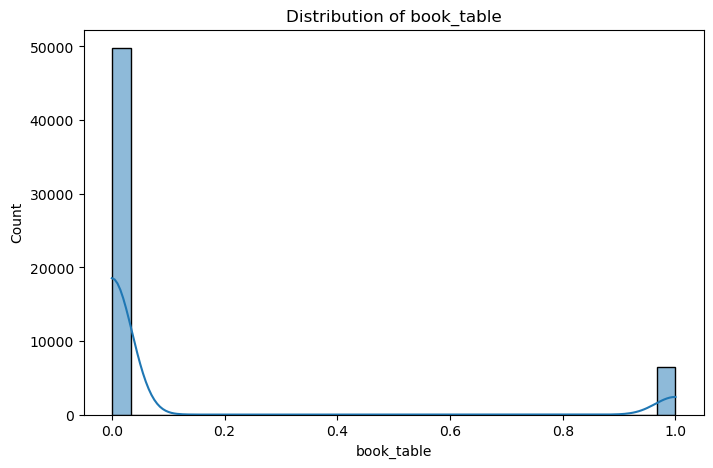

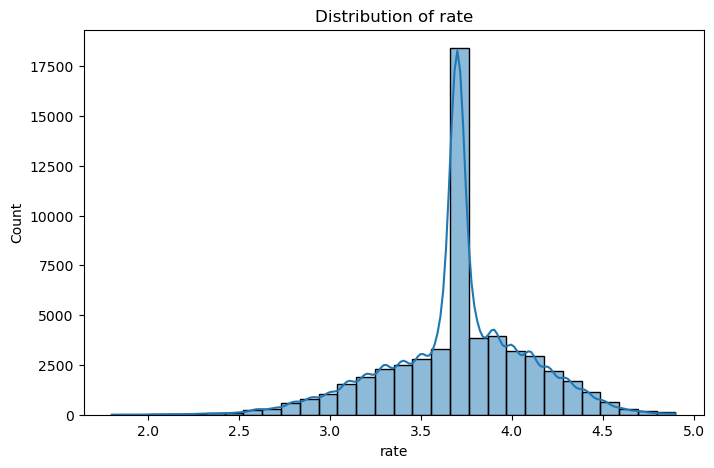

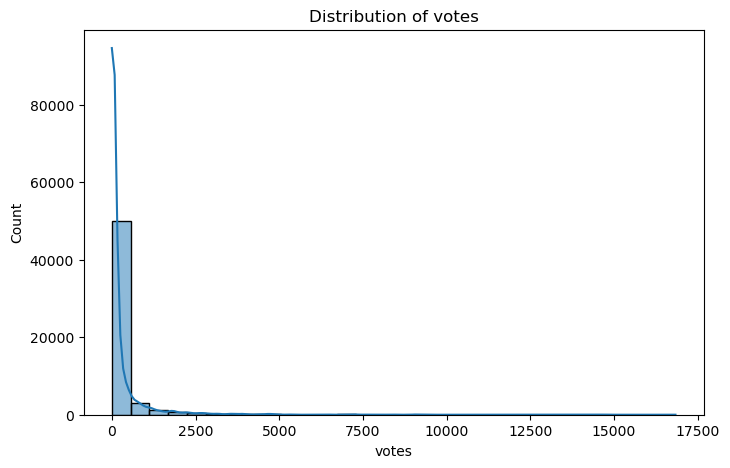

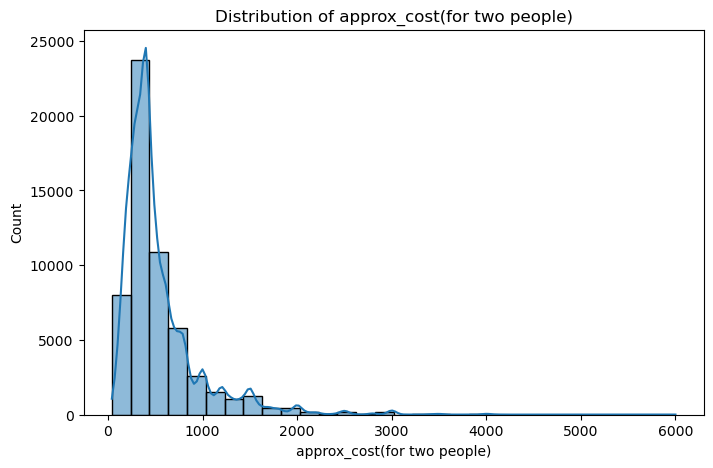

In [9]:
# Plot histograms for the numerical columns
numerical_cols = ['online_order', 'book_table', 'rate', 'votes', 'approx_cost(for two people)']
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

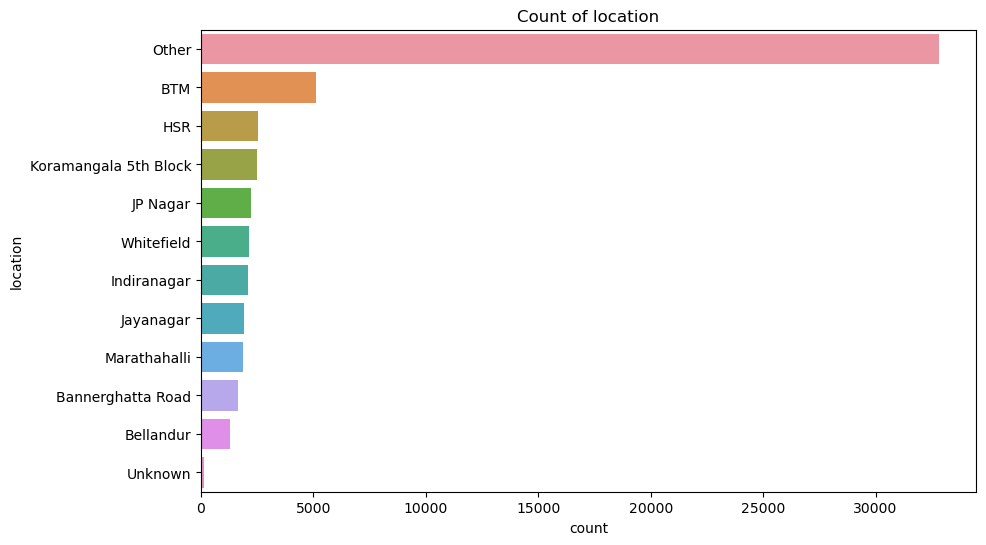

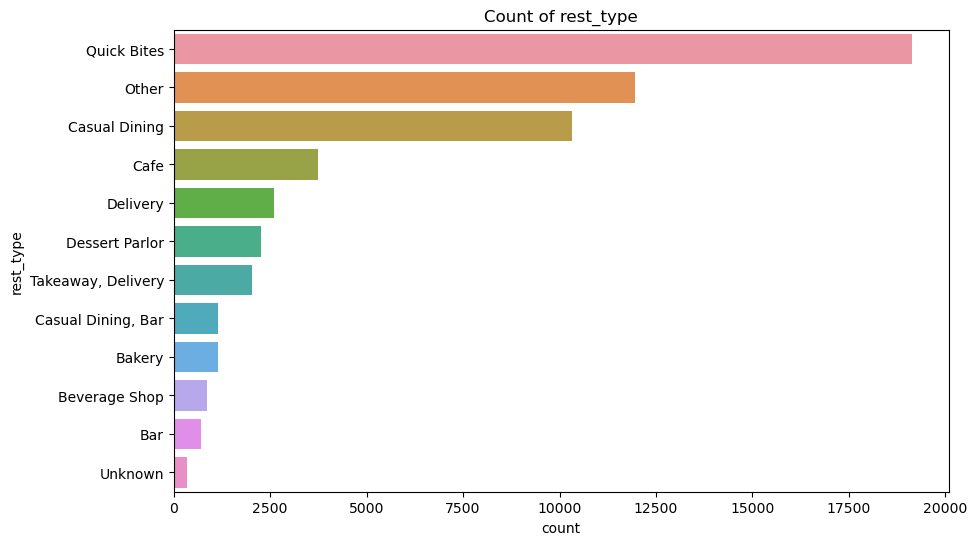

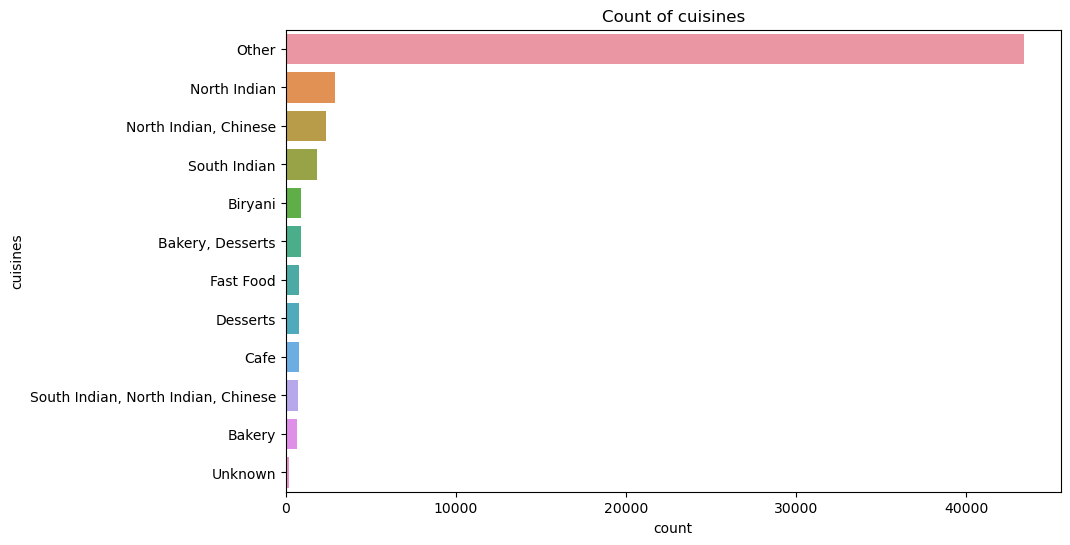

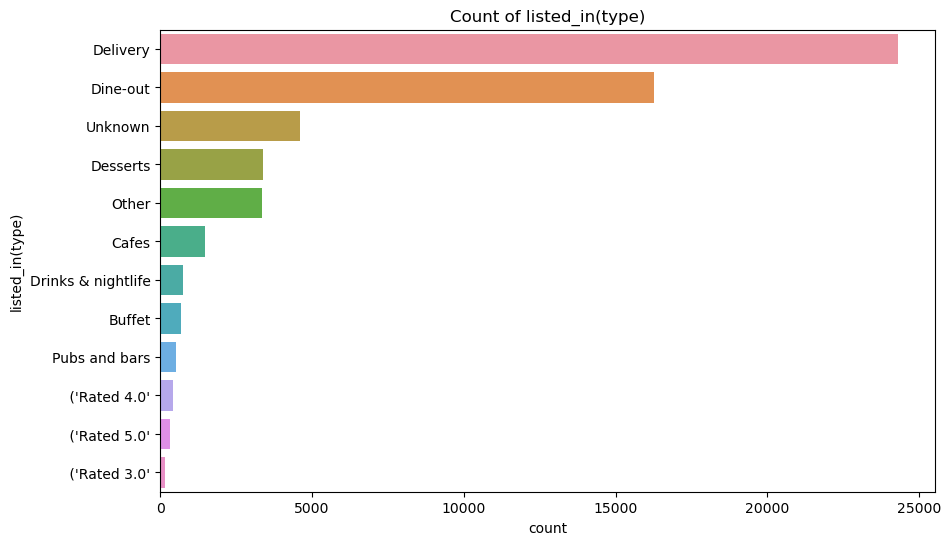

In [10]:
# Plot count plots for the categorical columns
categorical_cols = ['location', 'rest_type', 'cuisines', 'listed_in(type)']
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=col, data=data, order=data[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.show()

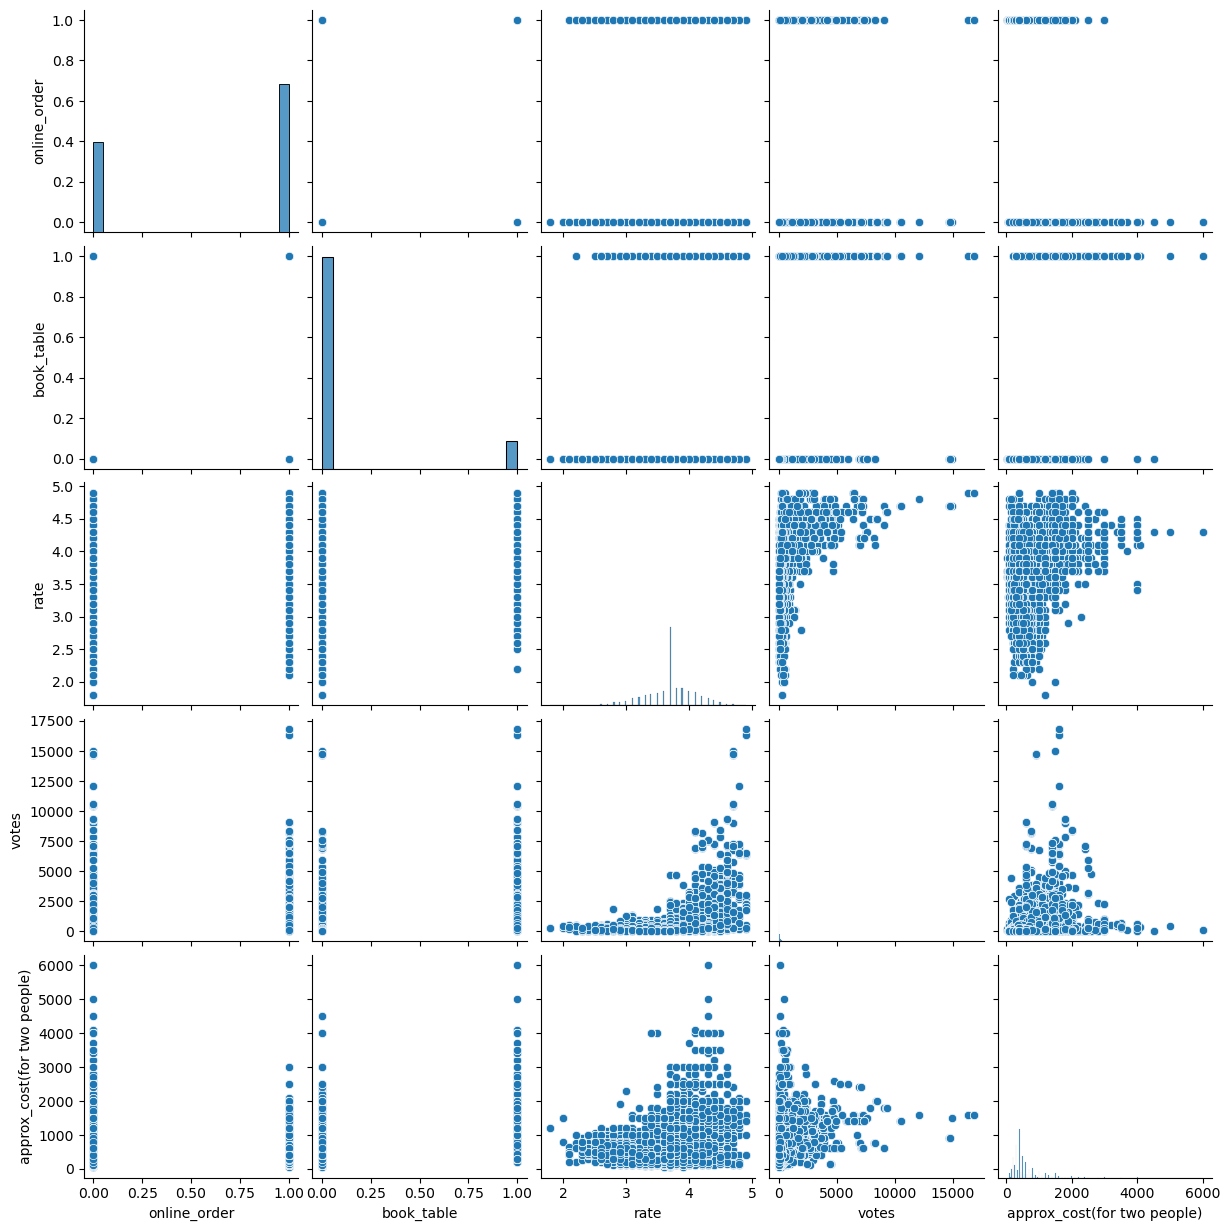

In [11]:
# Create a pairplot for the numerical variables
sns.pairplot(data[numerical_cols])
plt.show()

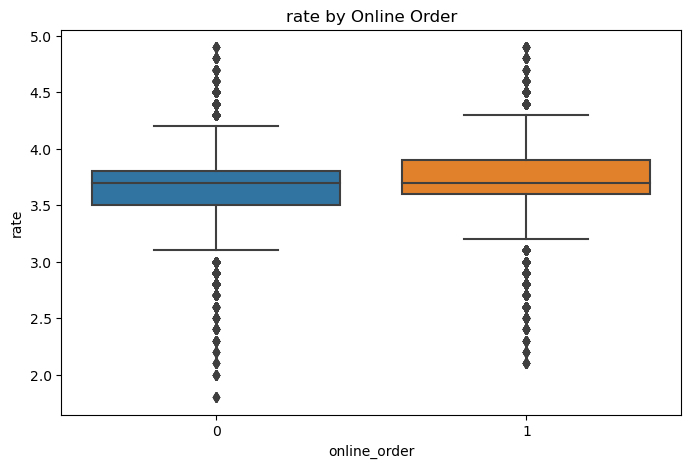

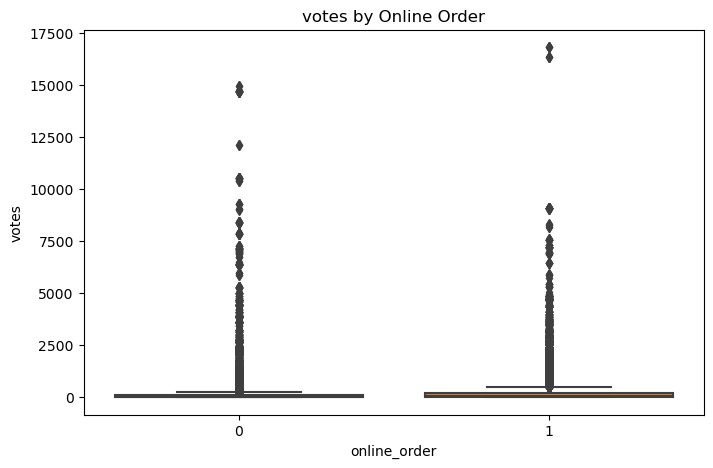

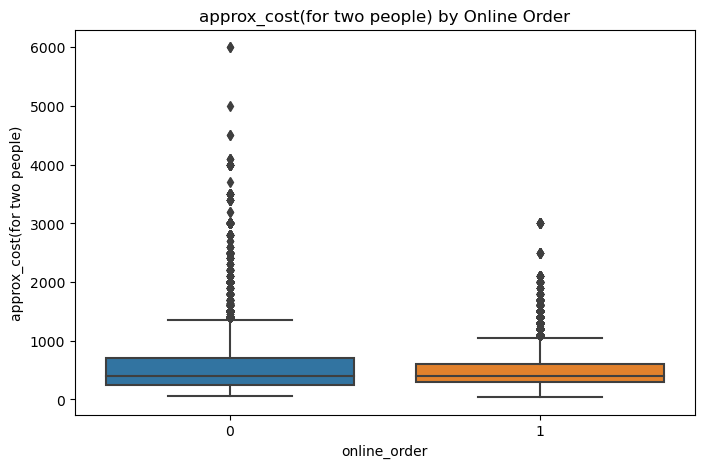

In [12]:
# Create box plots to compare the distributions of 'rate', 'votes', and 'approx_cost(for two people)'
# for online order accepting and non-accepting restaurants
for col in ['rate', 'votes', 'approx_cost(for two people)']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='online_order', y=col, data=data)
    plt.title(f'{col} by Online Order')
    plt.show()

In [13]:
# Feature Engineering: Adding a new column 'expensive' based on the 'approx_cost(for two people)'
# We consider a restaurant as expensive if the cost for two people is higher than the median
median_cost = data['approx_cost(for two people)'].median()
data['expensive'] = data['approx_cost(for two people)'].apply(lambda x: 1 if x > median_cost else 0)

# Drop the original 'approx_cost(for two people)' column
data = data.drop(columns='approx_cost(for two people)')

# Check the first few rows of the dataframe
data.head()

,online_order,book_table,rate,votes,location,rest_type,cuisines,listed_in(type),expensive
0,1,1,4.1,775.0,Other,Casual Dining,Other,Buffet,1
1,1,0,4.1,787.0,Other,Casual Dining,Other,Buffet,1
2,1,0,3.8,918.0,Other,Other,Other,Buffet,1
3,0,0,3.7,88.0,Other,Quick Bites,Other,Buffet,0
4,0,0,3.8,166.0,Other,Casual Dining,Other,Buffet,1


In [14]:
# Select the predictors and the target variable
X = data.drop(columns='expensive')
y = data['expensive']

# Apply one-hot encoding to the categorical variables
encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Check the shapes of the training set and the test set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((45001, 2403), (11251, 2403), (45001,), (11251,))

In [15]:
# Scale the data with MaxAbsScaler
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the first few rows of the scaled data
X_train_scaled[:5, :5]

<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [17]:
# Define the models
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(max_depth=10, random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

# Train, predict, and evaluate each model
model_scores = []
for name, model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    model_scores.append((name, accuracy, precision, recall, f1))

# Create a dataframe to store the scores of all models
model_scores_df = pd.DataFrame(model_scores, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Display the scores of all models
model_scores_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.868101,0.889448,0.795171,0.839672
1,Decision Tree,0.863301,0.927277,0.743605,0.825346
2,Random Forest,0.924362,0.940227,0.881932,0.910147
3,Gradient Boosting,0.862323,0.902169,0.766114,0.828594


Clustering for restaurant segmentation and insights

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


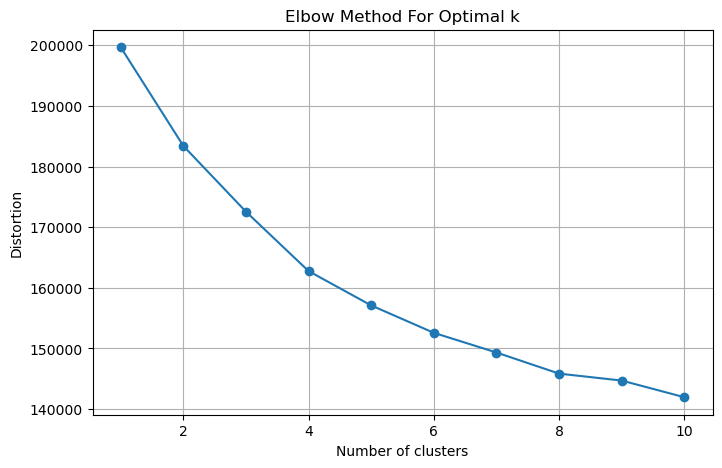

In [18]:
# Determine the optimal number of clusters using the elbow method
distortions = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_scaled)
    distortions.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [19]:
# Fit the K-Means model with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_train_scaled)

# Get the cluster assignments for each instance
clusters_train = kmeans.labels_

# Predict the clusters for test data
clusters_test = kmeans.predict(X_test_scaled)

# Combine train and test data back together
clusters = np.concatenate((clusters_train, clusters_test))

# Add the cluster assignments to the dataframe
data['cluster'] = clusters
# Display the first few rows of the dataframe
data.head()

,online_order,book_table,rate,votes,location,rest_type,cuisines,listed_in(type),expensive,cluster
0,1,1,4.1,775.0,Other,Casual Dining,Other,Buffet,1,3
1,1,0,4.1,787.0,Other,Casual Dining,Other,Buffet,1,2
2,1,0,3.8,918.0,Other,Other,Other,Buffet,1,1
3,0,0,3.7,88.0,Other,Quick Bites,Other,Buffet,0,2
4,0,0,3.8,166.0,Other,Casual Dining,Other,Buffet,1,2


In [20]:
# Calculate mean of numerical features for each cluster
numerical_cols = ['online_order', 'book_table', 'rate', 'votes', 'expensive']
cluster_means = data.groupby('cluster')[numerical_cols].mean()

# Calculate mode of categorical features for each cluster
categorical_cols = ['location', 'rest_type', 'cuisines', 'listed_in(type)']
cluster_modes = data.groupby('cluster')[categorical_cols].agg(lambda x: x.value_counts().index[0])

# Combine the mean and mode dataframes
cluster_characteristics = pd.concat([cluster_means, cluster_modes], axis=1)

cluster_characteristics

,online_order,book_table,rate,votes,expensive,location,rest_type,cuisines,listed_in(type)
cluster,,,,,,,,,
0,0.621515,0.118477,3.710776,269.834525,0.439153,Other,Quick Bites,Other,Delivery
1,0.619833,0.113497,3.696125,258.031312,0.438115,Other,Quick Bites,Other,Delivery
2,0.625581,0.113260,3.698700,268.542765,0.430781,Other,Quick Bites,Other,Delivery
3,0.609517,0.116744,3.698377,248.144541,0.439849,Other,Quick Bites,Other,Delivery


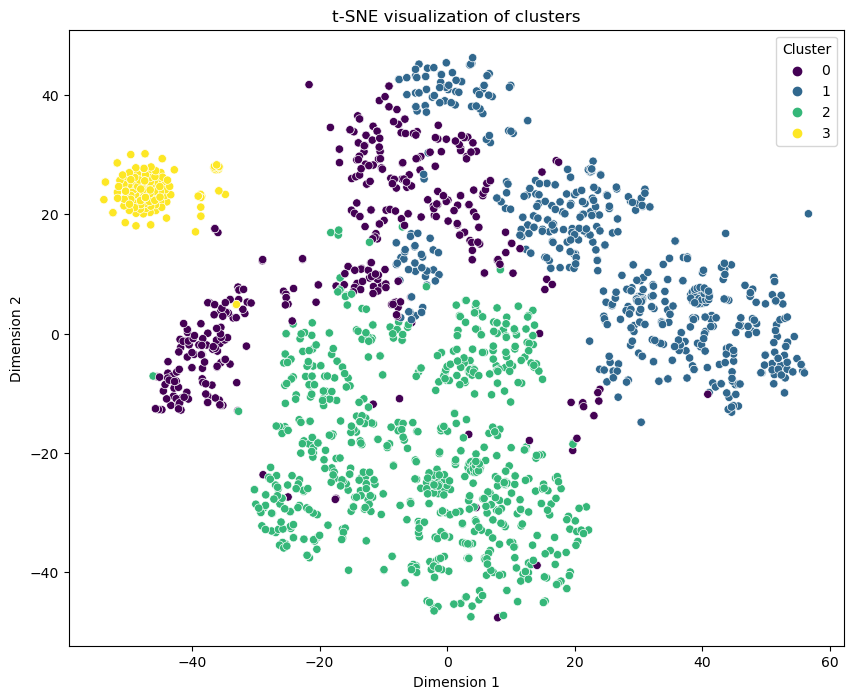

In [21]:
# Apply t-SNE to the data
sample_indices = random.sample(range(X_train_scaled.shape[0]), 2000)
X_sample = X_train_scaled[sample_indices]
clusters_sample = clusters_train[sample_indices]

tsne = TSNE(n_components=2, init='random', random_state=42)
X_sample_tsne = tsne.fit_transform(X_sample.toarray())  # Convert sparse matrix to dense

# Create a DataFrame to hold the t-SNE results
tsne_df = pd.DataFrame(data=X_sample_tsne, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Cluster'] = clusters_sample
# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Cluster', palette='viridis', data=tsne_df)
plt.title('t-SNE visualization of clusters')
plt.show()